In [ ]:
!pip install seaborn
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 14.7 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.8 MB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 30.2 MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [4]:
df = pd.read_csv('./../../labeledTweets/p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,negative
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,negative
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",negative
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,negative
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,negative


In [6]:
label_dict = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df.label.replace(label_dict) 
df['label'].value_counts()

0    77028
1    51994
2    45622
Name: label, dtype: int64

In [7]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message_lv_tilde']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message_lv_tilde,label,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...


# Train, validate split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [9]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label data_type                                        
0     train      65474             65474          65474
      val        11554             11554          11554
1     train      44195             44195          44195
      val         7799              7799           7799
2     train      38778             38778          38778
      val         6844              6844           6844

In [10]:
df.head()

,id,message_lv_tilde,label,clean_message,data_type
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...,train
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...,train
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a...",train
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...,train
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...,val


## Balance training data

In [11]:
df[df.data_type=='train']['label'].value_counts()

0    65474
1    44195
2    38778
Name: label, dtype: int64

In [12]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [13]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173549,Negadījums. divas labās joslas bloķētas TriSta...,0
13774,"labākais, ko ab ir pilnībā ielenkusi tukši dzī...",2
86302,"Piemērojot to visu šajā nākamajā nodaļā, uzspi...",1
77847,"MENTION Es cerēju, ka jūs galu galā izdarīsiet...",1
14670,"MENTION MENTION MENTION MENTION MENTION Jā, mē...",2


# Tokenizer "bert-base-multilingual-cased"

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

### Find max length for tokenizer

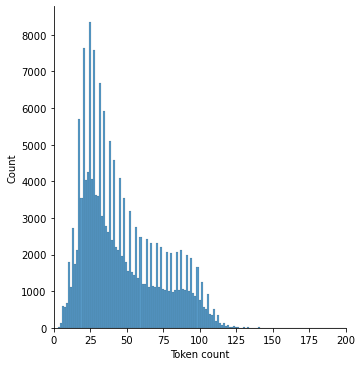

In [15]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [16]:
max_length = 150

### Encode messages

In [17]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
len(dataset_train), len(dataset_val)

(116334, 26197)

In [ ]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [ ]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [ ]:
# len(dataset_train), len(dataset_val)

# Model "bert-base-multilingual-cased"

In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [ ]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [25]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [21]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsCleaned/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0689003232753638
Validation loss: 0.959876549243927
F1 Score (Weighted): 0.5869284549912482
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       145
           1       0.51      0.32      0.40        62
           2       0.50      0.71      0.59        97

    accuracy                           0.59       304
   macro avg       0.58      0.55      0.55       304
weighted avg       0.60      0.59      0.59       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         91        8       46
       positive        20       20       22
       negative        17       11       69


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9396250681443648
Validation loss: 0.8772644817829132
F1 Score (Weighted): 0.6100656953450839
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       145
           1       0.46      0.53      0.49        62
           2       0.55      0.61      0.58        97

    accuracy                           0.61       304
   macro avg       0.58      0.59      0.58       304
weighted avg       0.62      0.61      0.61       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         92       20       33
       positive        14       33       15
       negative        19       19       59


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8610624580672293
Validation loss: 0.9123697340488434
F1 Score (Weighted): 0.5821079881667387
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.52      0.63       145
           1       0.37      0.66      0.47        62
           2       0.58      0.58      0.58        97

    accuracy                           0.57       304
   macro avg       0.58      0.59      0.56       304
weighted avg       0.64      0.57      0.58       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         76       41       28
       positive         9       41       12
       negative        11       30       56


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7909825245539347
Validation loss: 0.8510800540447235
F1 Score (Weighted): 0.6238110607747336
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       145
           1       0.44      0.61      0.51        62
           2       0.61      0.55      0.58        97

    accuracy                           0.62       304
   macro avg       0.60      0.61      0.60       304
weighted avg       0.64      0.62      0.62       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         97       26       22
       positive        12       38       12
       negative        22       22       53


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.7568148826107834
Validation loss: 0.8377163052558899
F1 Score (Weighted): 0.6191092978075229
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       145
           1       0.48      0.63      0.54        62
           2       0.58      0.56      0.57        97

    accuracy                           0.62       304
   macro avg       0.59      0.61      0.60       304
weighted avg       0.63      0.62      0.62       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         94       24       27
       positive        11       39       12
       negative        24       19       54


# Evaluate

In [26]:
model.load_state_dict(torch.load('modelsCleaned-pnn/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [27]:
print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.86      0.77      0.82     11554
           1       0.76      0.77      0.77      7799
           2       0.74      0.86      0.80      6844

    accuracy                           0.80     26197
   macro avg       0.79      0.80      0.79     26197
weighted avg       0.80      0.80      0.80     26197



In [28]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

predicted                  
                  neutral positive negative
actual neutral       8934     1403     1217
       positive       945     6006      848
       negative       488      452     5904

In [ ]:
unkTokens = [('️', 6950), ('😂', 6584), ('😭', 4354), ('…', 3449), ('🤣', 2423), ('❤', 2236), ('🏾', 2207), ('🏽', 1932), ('🙏', 1883), ('🔥', 1249), ('🏻', 1242), ('✨', 1213), ('🏼', 1209), ('🤷', 1165), ('–', 1057), ('🤦', 1025), ('🥺', 1018), ('😩', 993), ('🥰', 869), ('🤔', 846), ('🥴', 823), ('👏', 820), ('💯', 816), ('😍', 789), ('🙄', 718), ('🇺', 670), ('🙌', 664), ('💙', 623), ('🇸', 612), ('“Es', 596), ('💀', 573), ('👀', 561), ('—', 556), ('“', 539), ('😅', 530), ('💜', 527), ('💕', 519), ('😊', 482), ('👍', 455), ('💪', 454), ('😘', 445), ('😔', 428), ('💔', 422), ('😒', 417), ('🚨', 412), ('🙃', 403), ('🏿', 390), ('🚀', 387), ('😎', 377), ('‼', 375), ('😉', 361), ('🎄', 356), ('😁', 351), ('🖤', 335), ('😌', 332), ('😢', 328), ('🎶', 317), ('🎉', 307), ('🤗', 300), ('😆', 295), ('✊', 282), ('✌', 280), ('💛', 279), ('🥳', 278), ('😤', 276), ('😳', 275), ('🌟', 274), ('🤬', 267), ('👌', 261), ('👇', 261), ('🤩', 257), ('😬', 256), ('💖', 253), ('😡', 249), ('☺', 245), ('💋', 244), ('🌹', 244), ('⠀', 243), ('🤍', 242), ('🗣', 240), ('😫', 238), ('💚', 226), ('❄', 219), ('💗', 207), ('😈', 204), ('🙂', 197), ('😞', 195), ('😂,', 190), ('”', 190), ('😷', 188), ('🇷', 188), ('🤯', 188), ('😀', 185), ('“vai', 181), ('⃣', 181), ('💰', 177), ('😭,', 176), ('😴', 175), ('😏', 172), ('🤞', 171)]